<a href="https://colab.research.google.com/github/yee030/S_Word2Vec/blob/main/Shopping_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab에 Mecab 설치
!pip install konlpy
!pip install mecab-python

# Mecab을 Colab에 설치하기 위해 아래 스크립트를 실행
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)


  Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)
  Using cached JPype1-1.4.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (465 kB)
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1133k      0  0:00:01  0:00:01 --:--:-- 2342k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in
mecab-0.996-ko-0.9.2/mecab.iss.in
mecab-0.996-ko-0.9.2/config.guess
m

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#지정된 URL에서 데이터를 다운로드하여 "ratings_total.txt" 파일로 저장
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7b931493d000>)

In [ ]:
# 'ratings_total.txt' 파일을 읽어서 데이터프레임으로 저장
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

# 전체 리뷰 개수 출력
print('전체 리뷰 개수:', len(total_data))

전체 리뷰 개수: 200000


In [ ]:
# 데이터프레임의 처음 5개 행 출력
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [ ]:
# 'ratings' 열의 값이 3보다 큰 경우 'label' 열에 1을, 그렇지 않은 경우 0을 지정하여 추가
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

# 데이터프레임의 처음 5개 행 출력
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 'ratings' 열의 고유한 값 개수, 'reviews' 열의 고유한 값 개수, 'label' 열의 고유한 값 개수 출력
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
# 'reviews' 열에서 중복된 내용을 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)

# 중복이 제거된 후의 전체 데이터 개수를 출력
print('총 샘플의 수:', len(total_data))

총 샘플의 수: 199908


In [ ]:
# 데이터프레임에 결측값이 있는지 확인하고, 결측값이 존재하는지 여부를 출력
print(total_data.isnull().values.any())

False


In [ ]:
# 데이터를 훈련 데이터와 테스트 데이터로 분리합니다. 테스트 데이터의 비율은 25%로 지정하고, 난수 시드를 42로 설정
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)

# 훈련용 리뷰와 테스트용 리뷰의 개수를 출력
print('훈련용 리뷰의 개수:', len(train_data))
print('테스트용 리뷰의 개수:', len(test_data))


훈련용 리뷰의 개수: 149931
테스트용 리뷰의 개수: 49977


<Axes: >

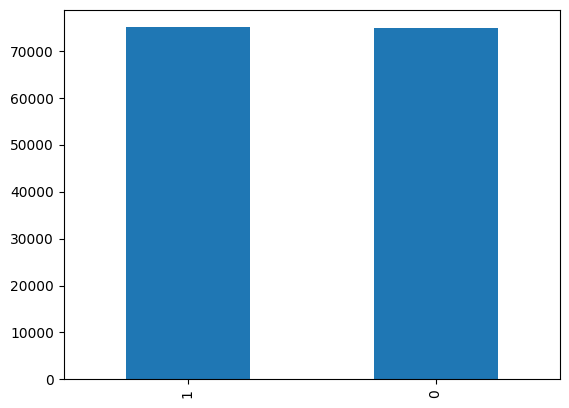

In [ ]:
# 'label' 열의 값별 개수를 세고, 막대 그래프로 시각화
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
# 'label' 열을 기준으로 그룹화하고, 각 그룹별로 개수를 센 후 'count'라는 열로 결과를 출력
print(train_data.groupby('label').size().reset_index(name='count'))


   label  count
0      0  74918
1      1  75013


In [ ]:
# 'reviews' 열에서 한글과 공백을 제외한 모든 문자를 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 빈 문자열로 바뀐 값들을 결측값(np.nan)으로 대체
train_data['reviews'].replace('', np.nan, inplace=True)

# 결측값의 개수를 출력
print(train_data.isnull().sum())


<ipython-input-13-e0486330aeaa>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# 테스트 데이터에서 중복된 내용을 제거
test_data.drop_duplicates(subset=['reviews'], inplace=True)

# 'reviews' 열에서 한글과 공백을 제외한 모든 문자를 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 공백은 Null 값으로 변경
test_data['reviews'].replace('', np.nan, inplace=True)

# Null 값이 존재하는 행을 제거
test_data = test_data.dropna(how='any')

# 전처리 후 테스트 데이터의 개수를 출력
print('전처리 후 테스트용 샘플의 개수:', len(test_data))


전처리 후 테스트용 샘플의 개수: 49977


<ipython-input-14-6449982e63ef>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
# Mecab 객체를 생성하고, 주어진 텍스트를 형태소로 분리합니다.
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [ ]:
# 제거할 불용어(stopwords) 리스트를 정의합니다.
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
# 'reviews' 열의 각 텍스트를 Mecab 형태소 분석을 통해 토큰화하고, 불용어를 제거
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
# 테스트 데이터의 'reviews' 열을 Mecab을 사용하여 형태소로 분리하고, 불용어를 제거
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [ ]:
# 부정 레이블(0)을 가진 데이터의 'tokenized' 열 값을 모두 합치기
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)

# 긍정 레이블(1)을 가진 데이터의 'tokenized' 열 값을 모두 합치기
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# 부정적인 리뷰에서 가장 많이 등장하는 단어 상위 20개를 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31802), ('는데', 20197), ('안', 19719), ('어요', 14838), ('있', 13200), ('너무', 13057), ('했', 11766), ('좋', 9803), ('배송', 9677), ('같', 8997), ('어', 8929), ('구매', 8869), ('거', 8861), ('없', 8672), ('아요', 8640), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7985)]


In [ ]:
# 긍정적인 리뷰에서 가장 많이 등장하는 단어 상위 20개를 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39422), ('아요', 21186), ('네요', 19894), ('어요', 18673), ('잘', 18603), ('구매', 16165), ('습니다', 13320), ('있', 12391), ('배송', 12274), ('는데', 11635), ('합니다', 9801), ('했', 9783), ('먹', 9640), ('재', 9274), ('너무', 8398), ('같', 7867), ('만족', 7259), ('거', 6484), ('어', 6330), ('쓰', 6291)]


긍정 리뷰의 평균 길이: 13.57963286363697
부정 리뷰의 평균 길이: 17.03147441202381


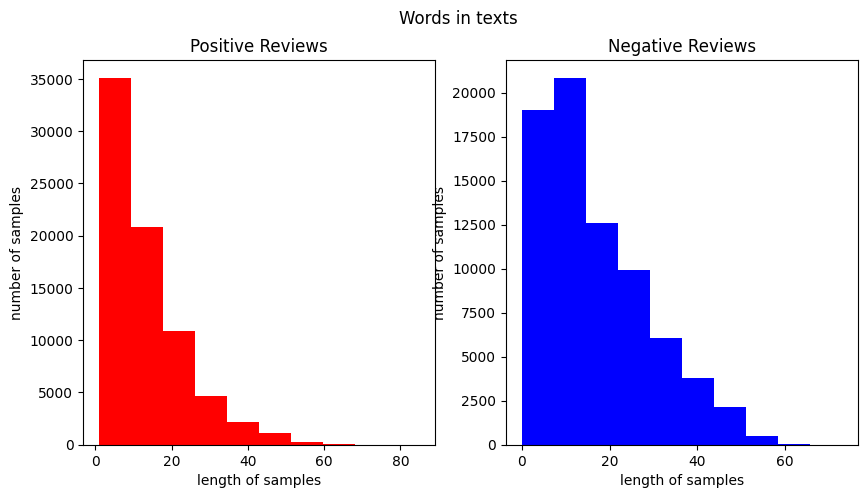

In [ ]:
# 두 개의 서브플롯(ax1, ax2)을 포함한 그림(figure)을 생성합니다.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 긍정 리뷰의 길이를 히스토그램으로 시각화합니다.
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이:', np.mean(text_len))

# 부정 리뷰의 길이를 히스토그램으로 시각화합니다.
text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이:', np.mean(text_len))

# 그림을 출력합니다.
plt.show()

In [ ]:
# 훈련 데이터와 테스트 데이터에서 토큰화된 리뷰 및 레이블을 추출
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values


In [ ]:
# Tokenizer 객체를 생성하고, 훈련 데이터의 텍스트를 이용하여 토큰화 학습을 수행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 등장 빈도수의 임계값(threshold) 설정
threshold = 5

# 전체 단어의 수를 계산
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수와 등장 빈도수의 합 계산을 위한 변수 초기화
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 각 단어와 그 단어의 등장 빈도수에 대해 반복
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value  # 훈련 데이터의 전체 단어 빈도수 총 합 계산

    # 단어의 등장 빈도수가 threshold보다 작은 경우
    if value < threshold:
        rare_cnt = rare_cnt + 1  # 등장 빈도수가 threshold보다 작은 희귀 단어 개수 증가
        rare_freq = rare_freq + value  # 등장 빈도수가 threshold보다 작은 희귀 단어의 등장 빈도수 합 증가

# 결과 출력
print('단어 집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)


단어 집합(vocabulary)의 크기: 40127
등장 빈도가 4번 이하인 희귀 단어의 수: 27585
단어 집합에서 희귀 단어의 비율: 68.7442370473746
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8766563250535058


In [ ]:
# 전체 단어 개수 중 빈도수 2 이하인 단어 개수를 제거하고, 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 크기를 계산
vocab_size = total_cnt - rare_cnt + 2

# 결과 출력
print('단어 집합의 크기:', vocab_size)


단어 집합의 크기: 12544


In [ ]:
# X_train과 X_test를 문자열 리스트로 변환
#'numpy.ndarray' object has no attribute 'lower라고 오류가 발생
#numpy.ndarray 객체에 대해 lower() 메서드를 호출을 시도 할려고 해서 발생
#해당 코드를 추가 해 줌으로서 tokenizer.fit_on_texts(X_train)에 대한 오류 해결

X_train_str = [str(sentence) for sentence in X_train]
X_test_str = [str(sentence) for sentence in X_test]

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Tokenizer 객체를 생성하고, 단어 집합의 크기와 OOV(Out of Vocabulary) 토큰을 설정하여 초기화
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')

In [ ]:
# 훈련 데이터의 텍스트를 이용하여 토큰화 학습을 수행.+

# 텍스트 데이터를 정수 시퀀스로 변환.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

AttributeError: ignored

In [ ]:
# 훈련 데이터의 첫 3개 샘플의 정수 시퀀스를 출력
print(X_train[:3])

In [ ]:
# 테스트 데이터의 첫 3개 샘플의 정수 시퀀스를 출력
print(X_test[:3])

In [ ]:
# 리뷰의 최대 길이 출력
print('리뷰의 최대 길이:', max(len(review) for review in X_train))

# 리뷰의 평균 길이 출력
print('리뷰의 평균 길이:', sum(map(len, X_train)) / len(X_train))

# 리뷰의 길이 분포를 히스토그램으로 시각화
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [ ]:
# 최대 길이(max_len)를 80으로 설정하여 훈련 데이터에서 길이가 max_len 이하인 샘플의 비율을 출력
max_len = 80
below_threshold_len(max_len, X_train)


In [ ]:
# 시퀀스 데이터를 패딩하여 길이를 최대 길이(max_len)에 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 임베딩 차원과 숨겨진 유닛 수를 설정하여 순차 모델을 생성합니다.
embedding_dim = 100
hidden_units = 128
model = Sequential()

# Embedding 층을 추가하여 단어를 밀집 벡터로 임베딩합니다.
model.add(Embedding(vocab_size, embedding_dim))

# GRU (Gated Recurrent Unit) 층을 추가합니다.
model.add(GRU(hidden_units))

# 출력 층을 추가하고 시그모이드 활성화 함수를 사용하여 이진 분류를 수행합니다.
model.add(Dense(1, activation='sigmoid'))

# 조기 종료(Early Stopping)와 모델 체크포인트(Model Checkpoint) 콜백을 설정합니다.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델을 컴파일합니다.
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 모델을 훈련합니다.
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


In [ ]:
import matplotlib.pyplot as plt

# 훈련 과정에서 기록된 손실과 정확도 값을 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

# 손실 그래프 그리기
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 저장된 모델을 불러옵니다.
loaded_model = load_model('best_model.h5')

# 테스트 데이터에 대한 정확도를 평가하고 출력합니다.
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


In [ ]:
def sentiment_predict(new_sentence):
    # 특수문자 및 불용어 처리
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]

    # 토큰화, 패딩, 모델 예측
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)

    score = float(loaded_model.predict(pad_new))

    # 확률에 따라 리뷰 감정 예측 결과 출력
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')


In [ ]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')


In [ ]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')


In [ ]:
sentiment_predict('존좋')


In [ ]:
sentiment_predict('개굿')
